First, need to create the panel dataset from the cross-sectional one.

In [315]:
import pandas as pd
import missingno as msno
import seaborn as sns
from datetime import datetime, timedelta

In [316]:
df_games = pd.read_csv('games_reviews_flat.csv')
df_games.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-05
1,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,20.0,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953,2020-11-30
2,2508,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.0,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007,2019-09-10
3,2510,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,True,eFootball PES 2020,eFootball PES 2020,...,83.0,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007,2019-09-10
4,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,14.0,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008,2020-02-27


In [317]:
df_games.columns

Index(['Unnamed: 0', 'igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate',
       'variable', 'igdb_company_id', 'developer', 'publisher', 'stock_id',
       'date'],
      dtype='object')

In [318]:
# Convert the date column to datetime64.
df_games['date'] = pd.to_datetime(df_games['date'])

In [319]:
df_games.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date             object
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [320]:
# Drop unused columns.
columns_to_drop = ['Unnamed: 0', 'variable', 'first_release_date', 'slug', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate', 'igdb_company_id']
df_games = df_games.drop(columns_to_drop, axis=1)

In [321]:
# Create column for holding the number of days that have passed since the release of the review.
df_games['days_from_review'] = 0

In [322]:
df_games.columns

Index(['igdb_id', 'name', 'mature', 'single_player', 'multiplayer',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review'],
      dtype='object')

In [323]:
# Function for changing date to next weekday if date is a weekend.
def next_weekday(date):
    while date.weekday() > 4:
        date += timedelta(days=1)
    return date

In [324]:
# Create a new DataFrame to store the additional rows
new_rows = pd.DataFrame(columns=df_games.columns)

# Iterate over each row in the original DataFrame
for index, row in df_games.iterrows():
    # Get the values from the current row
    igdb_id = row['igdb_id']
    name = row['name']
    mature = row['mature']
    single_player = row['single_player']
    multiplayer = row['multiplayer']
    igdb_name = row['igdb_name']
    opencritic_name = row['opencritic_name']
    opencritic_id = row['opencritic_id']
    dist = row['dist']
    hasLootBoxes = row['hasLootBoxes']
    percentRecommended = row['percentRecommended']
    numReviews = row['numReviews']
    numTopCriticReviews = row['numTopCriticReviews']
    medianScore = row['medianScore']
    topCriticScore = row['topCriticScore']
    percentile = row['percentile']
    developer = row['developer']
    publisher = row['publisher']
    stock_id = row['stock_id']
    date = row['date']

    

    # Create new rows with the additional observations
    dict_1 = {
        'date': next_weekday(date + pd.Timedelta(days=1)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 1
        }
    dict_1 = {k:[v] for k,v in dict_1.items()} 
    new_rows_1 = pd.DataFrame(dict_1)
    new_rows = pd.concat([new_rows, new_rows_1])

    dict_3 = {
        'date': next_weekday(date + pd.Timedelta(days=3)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 3
        }
    dict_3 = {k:[v] for k,v in dict_3.items()} 
    new_rows_3 = pd.DataFrame(dict_3)
    new_rows = pd.concat([new_rows, new_rows_3])

    dict_10 = {
        'date': next_weekday(date + pd.Timedelta(days=10)),
        'igdb_id': igdb_id,
        'name': name,
        'mature': mature,
        'single_player': single_player,
        'multiplayer': multiplayer,
        'igdb_name': igdb_name,
        'opencritic_name': opencritic_name,
        'opencritic_id': opencritic_id,
        'dist': dist,
        'hasLootBoxes': hasLootBoxes,
        'percentRecommended': percentRecommended,
        'numReviews': numReviews,
        'numTopCriticReviews': numTopCriticReviews,
        'medianScore': medianScore,
        'topCriticScore': topCriticScore,
        'percentile': percentile,
        'developer': developer,
        'publisher': publisher,
        'stock_id': stock_id,
        'days_from_review': 10
        }
    dict_10 = {k:[v] for k,v in dict_10.items()} 
    new_rows_10 = pd.DataFrame(dict_10)
    new_rows = pd.concat([new_rows, new_rows_10])

# Append the new rows to the original DataFrame
df_games = pd.concat([df_games, new_rows], ignore_index=True)
df_games.head()

,igdb_id,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,dist,hasLootBoxes,...,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,developer,publisher,stock_id,date,days_from_review
0,117,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,0.0,False,...,128.0,96.0,85.0,80.528736,83.0,False,True,JP3435000009,2016-12-05,0
1,119386,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,0.0,False,...,60.0,40.0,62.5,62.378378,20.0,False,True,SE0008294953,2020-11-30,0
2,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,71.0,48.0,82.0,81.270833,83.0,True,False,JP3300200007,2019-09-10,0
3,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,71.0,48.0,82.0,81.270833,83.0,False,True,JP3300200007,2019-09-10,0
4,120175,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,0.0,False,...,76.0,52.0,60.0,58.549020,14.0,False,True,JP3778630008,2020-02-27,0


In [325]:
# Check that adding the rows in has worked correctly.
df_games[['name', 'date', 'topCriticScore', 'days_from_review']][df_games['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review
0,The Last Guardian,2016-12-05,80.528736,0
1024,The Last Guardian,2016-12-06,80.528736,1
1025,The Last Guardian,2016-12-08,80.528736,3
1026,The Last Guardian,2016-12-15,80.528736,10


Now need to join the financial data onto this dataset.

In [326]:
# stock_id is object and needs to be parsed as a string.
df_games['stock_id'] = df_games['stock_id'].astype('string')

In [327]:
# Parse first release date as datetime.
df_games['date'] = pd.to_datetime(df_games['date'], format='%Y-%m-%d')

In [328]:
df_games.dtypes

igdb_id                        object
name                           object
mature                         object
single_player                  object
multiplayer                    object
igdb_name                      object
opencritic_name                object
opencritic_id                  object
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
developer                      object
publisher                      object
stock_id               string[python]
date                   datetime64[ns]
days_from_review               object
dtype: object

In [329]:
# Load the financial data.
stock_ff_index_df = pd.read_csv('financial_data_clean.csv')
stock_ff_index_df.head()

/var/folders/8x/1nmny09d6jq3bt7nw4zs3_n80000gp/T/ipykernel_16916/322589675.py:2: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_ff_index_df = pd.read_csv('financial_data_clean.csv')


,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,stock_id,eu,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.0,506501.0,18.420,FR0000054470,True,...,NaN,0.118694,1.51540,0.008358,0.119848,0.263811,1.12040,2.048644e+09,2.295301e+09,0.004554
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.0,217260.0,18.155,FR0000054470,True,...,-0.020086,0.120013,1.52015,0.008388,0.120244,0.265097,1.12755,2.019171e+09,2.276717e+09,0.001953
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.0,267647.0,18.355,FR0000054470,True,...,-0.017867,0.119100,1.51770,0.008314,0.120219,0.264225,1.12115,2.041415e+09,2.288732e+09,0.002406
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.0,984676.0,19.900,FR0000054470,True,...,0.079385,0.120576,1.52115,0.008321,0.121265,0.264925,1.12630,2.213247e+09,2.492781e+09,0.008854
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.0,740257.0,20.120,FR0000054470,True,...,0.014699,0.121766,1.53145,0.008335,0.121264,0.265361,1.12370,2.237716e+09,2.514521e+09,0.006656


In [330]:
stock_ff_index_df.columns

Index(['Unnamed: 0', 'gvkey', 'iid', 'date', 'company_name',
       'shares_outstanding', 'trading_volume', 'closing_price', 'stock_id',
       'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'benchmark_price', 'returns', 'benchmark_returns', 'excess_return',
       'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD', 'EURUSD',
       'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [331]:
# stock_id is object and needs to be parsed as a string.
stock_ff_index_df['stock_id'] = stock_ff_index_df['stock_id'].astype('string')

In [332]:
# Convert stock_data_df date column to datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
stock_ff_index_df.dtypes

Unnamed: 0                               int64
gvkey                                    int64
iid                                     object
date                            datetime64[ns]
company_name                            object
shares_outstanding                     float64
trading_volume                         float64
closing_price                          float64
stock_id                        string[python]
eu                                        bool
jp                                        bool
us                                        bool
mkt-rf                                 float64
smb                                    float64
hml                                    float64
rmw                                    float64
cma                                    float64
rf                                     float64
benchmark_price                        float64
returns                                float64
benchmark_returns                      float64
excess_return

In [333]:
df_games_panel = pd.merge(df_games, stock_ff_index_df, how='left', on=['date', 'stock_id'])
df_games_panel.head()

,igdb_id,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,dist,hasLootBoxes,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,117,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,0.0,False,...,-0.022378,0.119329,1.27050,0.008741,0.109188,0.238425,1.0725,3.991704e+12,3.489148e+10,0.005334
1,119386,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,0.0,False,...,0.037110,0.112910,1.33505,0.009590,0.116962,0.266809,1.1962,2.785728e+10,3.258243e+09,0.001424
2,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,-0.007550,0.111570,1.23535,0.009321,0.103004,0.254910,1.1041,6.599384e+11,6.151286e+09,0.004829
3,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,-0.007550,0.111570,1.23535,0.009321,0.103004,0.254910,1.1041,6.599384e+11,6.151286e+09,0.004829
4,120175,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,0.0,False,...,0.037230,0.106388,1.28735,0.009092,0.103612,0.254278,1.0986,1.254300e+12,1.140410e+10,0.005621


In [334]:
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id
0,The Last Guardian,2016-12-05,80.528736,0,JP3435000009
1024,The Last Guardian,2016-12-06,80.528736,1,JP3435000009
1025,The Last Guardian,2016-12-08,80.528736,3,JP3435000009
1026,The Last Guardian,2016-12-15,80.528736,10,JP3435000009


In [335]:
df_games_panel = df_games_panel.drop_duplicates()
df_games_panel[['name', 'date', 'topCriticScore', 'days_from_review', 'stock_id', 'market_cap', 'mkt_cap_usd', 'shares_outstanding', 'closing_price']][df_games_panel['name'] == 'The Last Guardian']

,name,date,topCriticScore,days_from_review,stock_id,market_cap,mkt_cap_usd,shares_outstanding,closing_price
0,The Last Guardian,2016-12-05,80.528736,0,JP3435000009,3.991704e+12,3.489148e+10,1.263197e+09,3160.0
1024,The Last Guardian,2016-12-06,80.528736,1,JP3435000009,4.029600e+12,3.535974e+10,1.263197e+09,3190.0
1025,The Last Guardian,2016-12-08,80.528736,3,JP3435000009,4.119287e+12,3.605612e+10,1.263197e+09,3261.0
1026,The Last Guardian,2016-12-15,80.528736,10,JP3435000009,4.260765e+12,3.593103e+10,1.263197e+09,3373.0


In [336]:
df_games_panel.columns

Index(['igdb_id', 'name', 'mature', 'single_player', 'multiplayer',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'developer', 'publisher',
       'stock_id', 'date', 'days_from_review', 'Unnamed: 0', 'gvkey', 'iid',
       'company_name', 'shares_outstanding', 'trading_volume', 'closing_price',
       'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'benchmark_price', 'returns', 'benchmark_returns', 'excess_return',
       'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD', 'EURUSD',
       'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [337]:
# Drop unused columns.
df_games_panel = df_games_panel.drop([
    'Unnamed: 0',
    'iid',
    'gvkey',
    'shares_outstanding',
    'market_cap',
    'benchmark_price',
    'closing_price',
    'trading_volume',
    'returns',
    'NOKUSD',
    'GBPUSD',
    'JPYUSD',
    'SEKUSD',
    'PLNUSD',
    'EURUSD',
    'market_cap',
    'benchmark_returns'
    ], axis=1)

df_games_panel.head()

,igdb_id,name,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,dist,hasLootBoxes,...,us,mkt-rf,smb,hml,rmw,cma,rf,excess_return,mkt_cap_usd,volume_to_shares_outstanding
0,117,The Last Guardian,False,True,False,The Last Guardian,The Last Guardian,1524,0.0,False,...,False,-0.99,0.35,0.03,0.11,0.19,0.00,-0.022378,3.489148e+10,0.005334
1,119386,Empire of Sin,True,True,False,Empire of Sin,Empire of Sin,10595,0.0,False,...,False,-1.10,0.47,-1.31,0.02,-0.63,0.00,0.037110,3.258243e+09,0.001424
2,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,False,0.13,-0.17,2.90,-1.05,0.56,0.01,-0.007550,6.151286e+09,0.004829
3,119422,eFootball PES 2020,False,True,True,eFootball PES 2020,eFootball PES 2020,8187,0.0,NaN,...,False,0.13,-0.17,2.90,-1.05,0.56,0.01,-0.007550,6.151286e+09,0.004829
4,120175,One Punch Man: A Hero Nobody Knows,False,True,True,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,8787,0.0,False,...,False,-1.63,-0.86,0.56,-0.49,0.33,0.01,0.037230,1.140410e+10,0.005621


<Axes: >

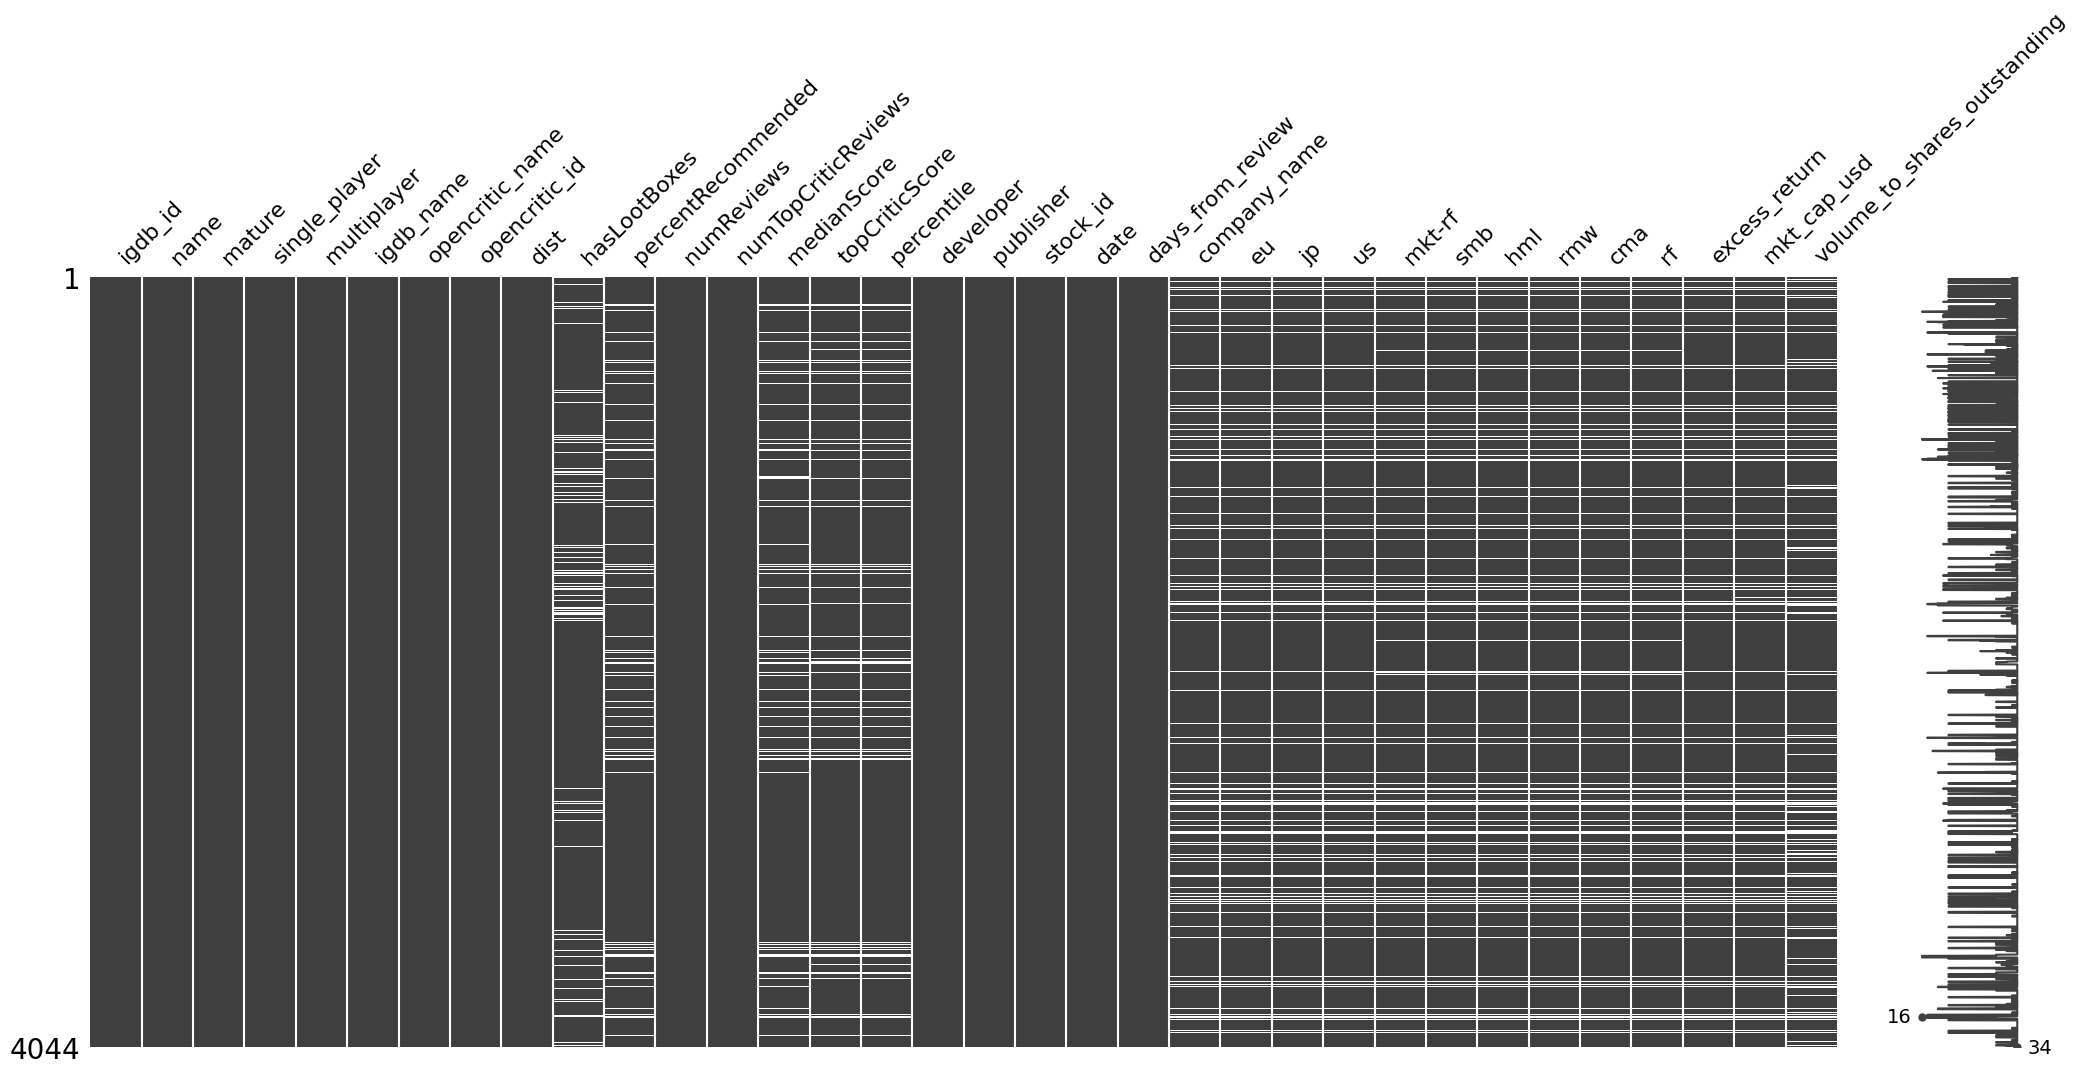

In [338]:
# Plot missing data.
%matplotlib inline

msno.matrix(df_games_panel)

In [339]:
df_games_panel = df_games_panel.dropna()

In [340]:
df_games_panel.shape

(2819, 34)

<Axes: xlabel='days_from_review', ylabel='Count'>

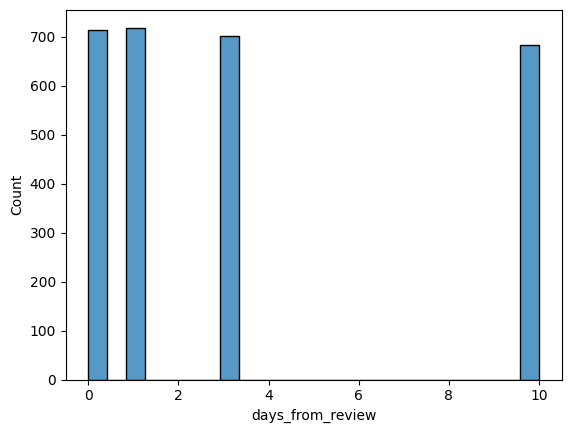

In [341]:
sns.histplot(df_games_panel['days_from_review'])